## Emotion Recognition based on facial landmarks




**Goal**: 
This notebook is about **emotion recognition** based on facial landmarks.


**Dataset**: 
We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.


First of all, we need to load the data. Let's load them from Google Drive.

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')

Let's load the Python packages containing the functions needed for this project


In [4]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

We also define a function useful for plotting the confusion matrix

In [5]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark positions should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [6]:
# Parameters
dim=2 # dimension   
# Loading data
Working_directory="./data/" 
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

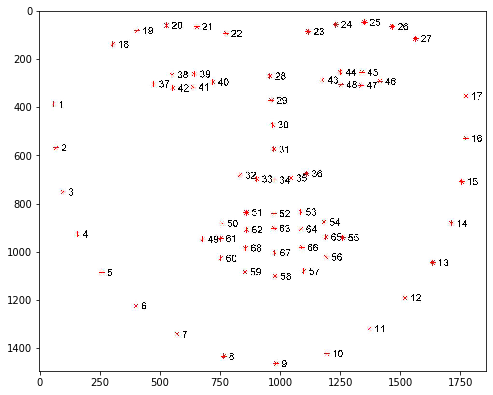

In [7]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

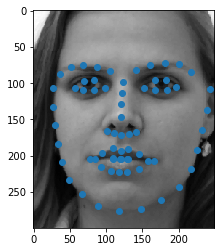

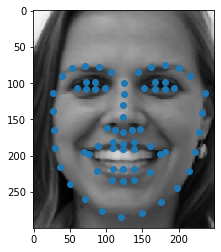

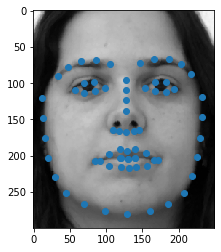

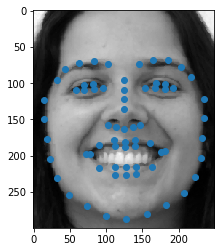

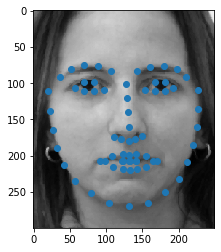

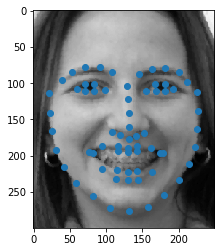

In [8]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---
we can see that the data is 2 pictures per person where the first is happy and the second neutral so we better shuffle the data randomly to avoid this pattern.



---

In [9]:
# Shuffle data randomly
permutation = np.arange(X.shape[0])
np.random.shuffle(permutation)

# Use as new variables
XpGPA=XGPA[permutation]
Xp=X[permutation]
Yp=Y[permutation]
Imagesp=Images[permutation]
Xmean=np.mean(XpGPA,axis=0) # Compute average
Namesp=Names[permutation]




---



The variation in the  aligned landmarks is less  than the variation in the orignal landmarks. that being said the alignement of of the landmarks make the changes due to emotion change is more obvious  since we have only few variations , any major variation would be logicaly due to emotion change thus we could say that the alignement  landmarks with Generalized Procrustes Analysis enables us to eliminate the variations in landmarks that are not significant to the emotion decision ( scaling , rotation ). 
In other words we eliminated the changes due to these transformation ( we can concider it as noise  in our data ) and with GPA we rcover the orignal data without the noise of there transformations. 



---





Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

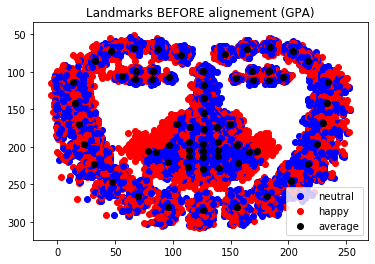

In [10]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

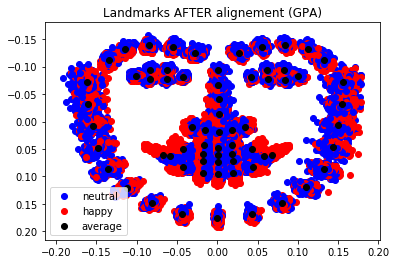

In [11]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the (aligned) landmarks of every subject and the landmarks of the average configuration. Please remember to use XpGPA.



---



In [12]:
# Compute distances from the average configuration (features)
dist = np.zeros((N,M))
for i in range(XpGPA.shape[0]):
  for j in range(0, XpGPA.shape[1]//2):
    dist[i][j] = paired_distances( [[XpGPA[i,j*2], XpGPA[i,2*j+1]]] , [[Xmean[2*j], Xmean[2*j+1]]] )
print(dist)

[[0.00258905 0.00205613 0.00297324 ... 0.01131283 0.01093802 0.01140833]
 [0.00443115 0.00288625 0.00285427 ... 0.01653513 0.01697774 0.01717356]
 [0.00100198 0.00201679 0.00282666 ... 0.00367861 0.00042429 0.00295172]
 ...
 [0.02160176 0.01940511 0.01722344 ... 0.01074349 0.00976458 0.00965798]
 [0.00710895 0.00395009 0.00104907 ... 0.00591282 0.00429471 0.00454745]
 [0.00781756 0.00666185 0.00686204 ... 0.00652567 0.00861915 0.01089884]]


---


**Normalization** is a good technique to use when we do not know the distribution of the data or when we know the distribution is not Gaussian. Since we don't know the the distribution of the data it would be a good  idea to do Normalization.


**Standardization** is useful when the data has varying scales and the algorithm  does make assumptions about the data having a Gaussian distribution, such as linear regression, logistic regression, and linear discriminant analysis.Since we don't know if the distribution of the data is Gaussian or not it would be a good  idea to do Standardization.

---

In [13]:
# Scale data (each feature will have average equal to 0 and unit variance)
dist_average=dist
scaler = StandardScaler()
scaler.fit(dist_average)
dist_average_scale=scaler.transform(dist_average)

# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
scaler.fit(dist_average)
dist_average_normal = scaler.transform(dist_average)

Let's divide the data-set into Training and Test sets using original, scaled and normalized data.

In [14]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

# Create training and test set form the scaled data
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(dist_average_scale, np.ravel(Yp), test_size=0.33, random_state=42)

# Create training and test set from the normalized data
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(dist_average_normal, np.ravel(Yp), test_size=0.33, random_state=42)

Fitting LDA to training set
done in 0.360s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

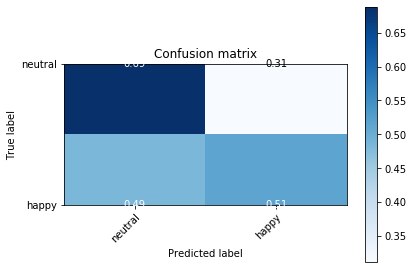

Fitting LDA to normlized training set
done in 0.013s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

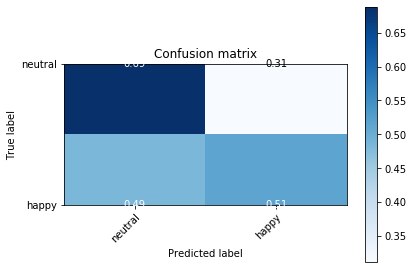

Fitting LDA to normlized training set
done in 0.015s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

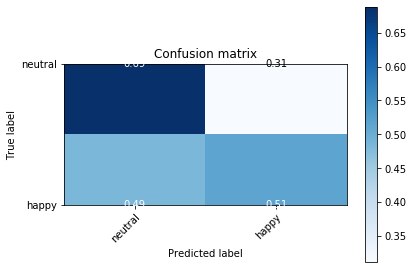

In [15]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()


# Fitting LDA to Normlized  data
print("Fitting LDA to normlized training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_normal, y_train_normal)
y_pred = lda.predict(X_test_normal)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()


# Fitting LDA to Scaled   data
print("Fitting LDA to normlized training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train_scale)
y_pred = lda.predict(X_test_scale)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()



---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 
 
$\implies $ Since there is no change in performnces between original, scaled and normalized data.  
LDA is capable of handling non Normlized / Scaled data.




---



In [16]:

# Cross-validation for Model Assessment
def compute_all(data):
    # Fitting LDA
    print("Fitting LDA")
    t0 = time()
    lda = LinearDiscriminantAnalysis()
    lda_score = cross_val_score(lda,X=data, y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

    # Fitting QDA
    print("Fitting QDA")
    t0 = time()
    qda = QuadraticDiscriminantAnalysis()
    qda_score = cross_val_score(qda,X=data, y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

    # Fitting Logistic-regression
    print("Fitting Logistic Regression")
    t0 = time()
    logit = LogisticRegression(solver='lbfgs')
    logit_score = cross_val_score(logit,X=data, y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

    # Fitting Naive-Bayes
    print("Fitting Naive-Bayes")
    t0 = time()
    GNB = GaussianNB()
    GNB_score = cross_val_score(GNB,X=data, y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

    # Fitting K-nearest neighbour
    print("Fitting K-nearest neighbour")
    t0 = time()
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh_score = cross_val_score(neigh,X=data, y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

In [17]:
print("Oiginal data")
compute_all(dist_average)
print("==============================================")
print("Normalized Data ")
compute_all(dist_average_normal)
print("==============================================")
print("Scaled Data ")
compute_all(dist_average_scale)
print("==============================================")

Oiginal data
Fitting LDA
done in 0.138s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.192s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.063s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.019s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.116s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824
Normalized Data 
Fitting LDA
done in 0.155s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.197s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.447s
 Average and std CV score : 0.5675000000000001 +- 0.03674234614174766
Fitting Naive-Bayes
done in 0.026s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.097s
 Average and std CV score : 0.57



---


No changes for (LDA,QDA,NaiveBayes) the performance are the same with or without Normalization/Standardization   of the data. 

$\implies$ Thus LDA , QDA  & Naive Bayes can Handel data without the need to a prior Normalization or Standardization

Yet, For KNN The score avarage decreased, that implies that KNN is sensible to  Normalization and Standardization of the data, Still theoretically the performance should get better if we do  ( Normalization and Standardization )  of data for KNN , which is not the Case.

For the Logistic Regression the perfermance increased for the scalled data but decreased for the normalized data.

$\implies$ Thus KNN & Logistic Regression are sensible to prior data  Normalization or Standardization.


---








---



In the previous example we have fixed the hyper-parameter K to 3. We coudl use CV to find the best value.



---



The best K is 7  with an average validation score equal to  0.6399999999999999


Text(0, 0.5, 'CV Validation Score')

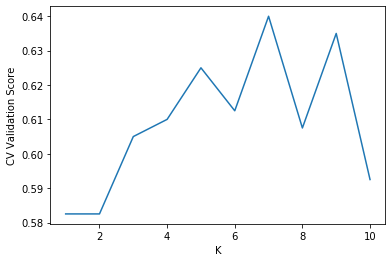

In [18]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 5  with an average validation score equal to  0.6044025157232704
The test score is 0.6590909090909091


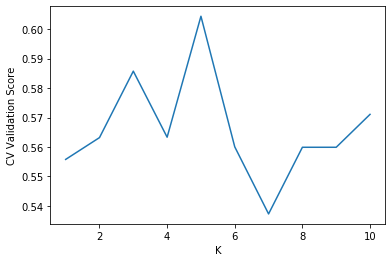

In [19]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---


Training on the whole data gives a better validation score.
and it make sense that K=7 when we train on the whole data and K=5 when we train on the  traing set only.
 
Actully We choose the biggest  K just before we get into the overfitting, since we added more data it make sense the K can get bigger without overfitting the model thus K=7.

---





---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [20]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))

for i in range(XpGPA.shape[0]):
  c = 0
  for j in range(0, XpGPA.shape[1],2):
    for k in range(0, XpGPA.shape[1],2):
      if k>j:
        break ## we don't to calculate the distance twice
    c += 1
    dist_combination[i][c] = paired_distances([[XpGPA[i,j], XpGPA[i,j+1]]] , [[XpGPA[i,k], XpGPA[i,k+1]]])
   
print(dist_combination)


[[0.         0.03993386 0.03860397 ... 0.         0.         0.        ]
 [0.         0.04364158 0.04119568 ... 0.         0.         0.        ]
 [0.         0.03996669 0.04049574 ... 0.         0.         0.        ]
 ...
 [0.         0.0388699  0.03776717 ... 0.         0.         0.        ]
 [0.         0.04041223 0.04088147 ... 0.         0.         0.        ]
 [0.         0.04320398 0.04226105 ... 0.         0.         0.        ]]


In [21]:
# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
scaler.fit(dist_combination)
dist_combination = scaler.transform(dist_combination)
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(dist_combination)
dist_combination = scaler.transform(dist_combination)



$\implies$the accuraccy increase for all models except QDA.


In [22]:
compute_all(dist_combination)

Fitting LDA
done in 1.412s
 Average and std CV score : 0.9550000000000001 +- 0.02179449471770338
Fitting QDA


/home/khalil/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khalil/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khalil/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khalil/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/khalil/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.644s
 Average and std CV score : 0.9025000000000001 +- 0.02783882181415013
Fitting Logistic Regression
done in 0.743s
 Average and std CV score : 0.96 +- 0.01837117307087381
Fitting Naive-Bayes
done in 0.132s
 Average and std CV score : 0.9400000000000001 +- 0.009354143466934821
Fitting K-nearest neighbour
done in 0.829s
 Average and std CV score : 0.9399999999999998 +- 0.026692695630078266




---

Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. We could use  PCA (Principal Component Analysis).



---



In [32]:
# We could use PCA to map the data to a new coordiante system where the new variables would be orthogonal among each other. (so no more collinear...)
pca = decomposition.PCA(n_components=0.9) # use number of components take explain 90% of variability
pca.fit(dist_combination)
dist_combination_pca = pca.transform(dist_combination)  

print('Number of subjects N is: ', dist_combination_pca.shape[0], ' ; number of features is: ',  dist_combination_pca.shape[1] )

Number of subjects N is:  400  ; number of features is:  16


The performance of all models increased with the use of variable selection 

In [24]:
compute_all(dist_combination_pca)

Fitting LDA
done in 0.039s
 Average and std CV score : 0.9549999999999998 +- 0.03020761493398643
Fitting QDA
done in 0.022s
 Average and std CV score : 0.9600000000000002 +- 0.02423839928708164
Fitting Logistic Regression
done in 0.082s
 Average and std CV score : 0.96 +- 0.021505813167606566
Fitting Naive-Bayes
done in 0.010s
 Average and std CV score : 0.95 +- 0.020916500663351895
Fitting K-nearest neighbour
done in 0.039s
 Average and std CV score : 0.9349999999999999 +- 0.018371173070873832




---


A second solution, would be to manually select few landmarks



---



In [25]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


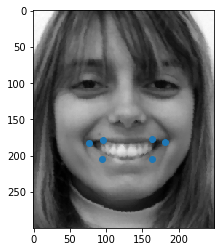

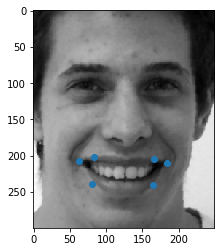

In [26]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

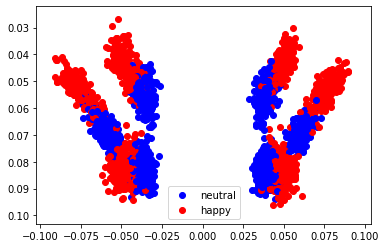

In [27]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [28]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.95625 +- 0.006846531968814562
 Average and std test score : 0.9400000000000001 +- 0.021505813167606556


---
subject who barely smile ( not much of variation  in the mouth ) the algorithm misclassified them. I think the landmarks only on the mouth are not enough, we should add some others to make it more efficient.


---

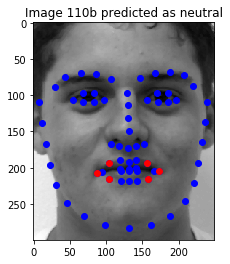

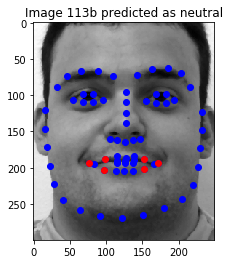

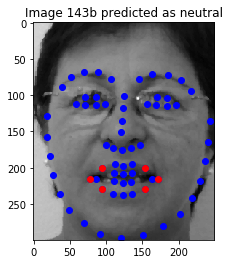

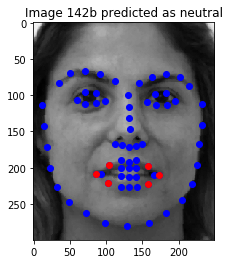

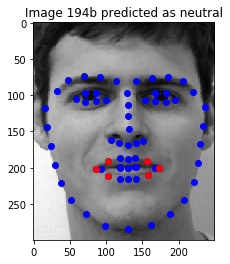

In [29]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [30]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 1.323s
Average and std Nested Cv train score : 0.9550000000000001 +- 0.004238956239453313
Average and std Nested Cv test score : 0.95 +- 0.022360679774997904


---

Here We added the eyebrows  landmark to the mouth method. 

And it achieved an accuracy of 0.9625 (+/- 0.0158) using cross validation.

---


Number of subjects N is:  400  ; number of features is:  24
Fitting LDA
 Average and std train score : 0.965625 +- 0.005229125165837967
 Average and std test score : 0.9625 +- 0.015811388300841892


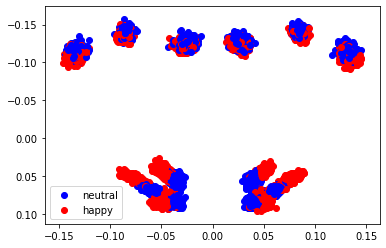

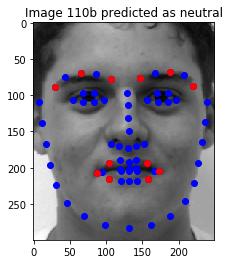

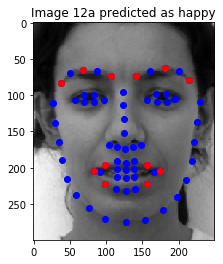

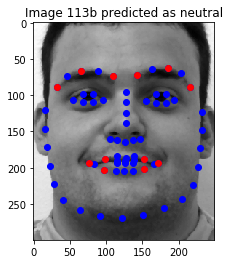

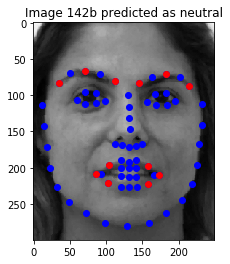

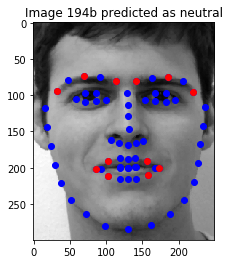

In [31]:
# Select lateral landmarks mouth
select_land=[18,20,22,23,25,27,49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

for i in range(0,kk):
      image = Imagesp[error[i],:,:]
      plt.figure()
      plt.imshow(image, cmap='gray', origin='upper')
      landmarkALL=Xp[error[i],:]
      landmark=Xps[error[i],:]
      xALL=landmarkALL[::2]
      yALL=landmarkALL[1::2]
      x=landmark[::2]
      y=landmark[1::2]
      plt.plot(xALL,yALL,'ob')
      plt.plot(x,y,'or')
      if  C[error[i]]==0:
          plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
      elif C[error[i]]==1:
          plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
      plt.show()